In [ ]:
!pip install -q tensorflow

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


#  RNN لمعالجة نصوص IMDB

**الهدف:** تصنيف مراجعات الأفلام (IMDB) إلى إيجابية/سلبية باستخدام RNN.

في هذا الدفتر سنقوم بـ:
- تحميل مجموعة بيانات IMDB
- تحضير النصوص (tokenization, padding)
- بناء نموذج Baseline باستخدام SimpleRNN
-  LSTM  بونص
- تقييم، حفظ وعمل inference على جمل جديدة


In [ ]:
#  Import and environment check
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

print('TF:', tf.__version__)


seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

TF: 2.20.0
GPU available: []


Train samples: 25000
Test samples: 25000

مثال لمراجعة رقمية (مشفرة):
[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447]

المراجعة بعد فك الترميز (مقتطف):
<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it


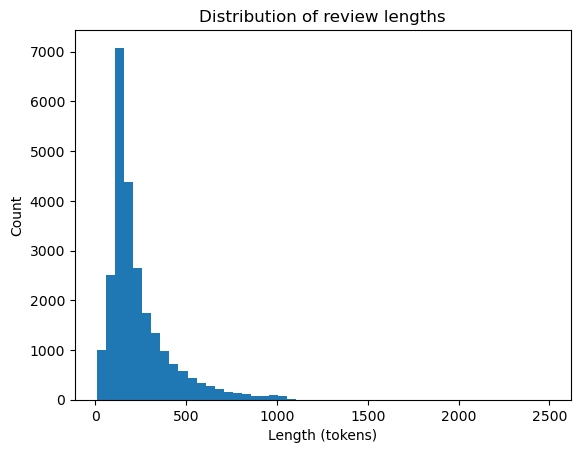

In [ ]:
#  تحميل واستكشاف بيانات IMDB

max_features = 10000  # عدد الكلمات الأعلى شيوعاً
(x_train, y_train), (x_test, y_test) = keras.datasets.imdb.load_data(num_words=max_features)

print('Train samples:', len(x_train))
print('Test samples:', len(x_test))

# دالة لفك الترميز (عرض مثال نصي)
word_index = keras.datasets.imdb.get_word_index()
index_word = {v+3:k for k,v in word_index.items()}  # +3 لأن بعض الرموز محجوزة
index_word[0] = '<PAD>'
index_word[1] = '<START>'
index_word[2] = '<UNK>'
index_word[3] = '<UNUSED>'

def decode_review(encoded):
    return ' '.join(index_word.get(i, '?') for i in encoded)

print('\nمثال لمراجعة رقمية (مشفرة):')
print(x_train[0][:50])
print('\nالمراجعة بعد فك الترميز (مقتطف):')
print(decode_review(x_train[0])[:400])

# طول الجمل
lengths = [len(x) for x in x_train]
plt.hist(lengths, bins=50)
plt.title('Distribution of review lengths')
plt.xlabel('Length (tokens)')
plt.ylabel('Count')
plt.show()


In [ ]:
#  تحضير البيانات (padding)
from tensorflow.keras.preprocessing.sequence import pad_sequences

maxlen = 200
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

print('x_train shape:', x_train.shape)

# دالة لعرض نتائج التوزيع للملصقات
import numpy as np
(unique, counts) = np.unique(y_train, return_counts=True)
print('\nLabel distribution (train):', dict(zip(unique, counts)))


x_train shape: (25000, 200)

Label distribution (train): {np.int64(0): np.int64(12500), np.int64(1): np.int64(12500)}


In [ ]:
#  نموذج Baseline: Embedding -> SimpleRNN -> Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

vocab_size = max_features
embedding_dim = 128   #كل كلمة هتتحول إلى Vector طوله 128

model = keras.Sequential([
    layers.Embedding(vocab_size, embedding_dim, input_length=maxlen),
    layers.SimpleRNN(64),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

callbacks = [EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)]

# Quick test run: epochs=1 to verify training works
history = model.fit(x_train, y_train, validation_split=0.1, epochs=1, batch_size=128, callbacks=callbacks)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

176/176 ━━━━━━━━━━━━━━━━━━━━ 24s 118ms/step - accuracy: 0.7172 - loss: 0.5388 - val_accuracy: 0.8340 - val_loss: 0.3753


In [ ]:
#  تقييم وحفظ النموذج
loss, acc = model.evaluate(x_test, y_test, verbose=1)
print(f'Test loss: {loss:.4f}, Test accuracy: {acc:.4f}')

model.save('rnn_imdb_baseline.h5')
print('Saved model to rnn_imdb_baseline.h5')

# مثال inference على مراجعة جديدة (نستخدم المعجم لفك الترميز ثم إعادة الترميز بسرعة)
sample_text = "This movie was fantastic! I loved it and the acting was superb"
# ملاحظة: للتحويل الصحيح للجُمل إلى أرقام نحتاج Tokenizer أو استخدام TextVectorization على نصوص خام
print('To do inference on raw text: use a TextVectorization layer or Tokenizer (see notebook comments).')

782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.8428 - loss: 0.3682


Test loss: 0.3682, Test accuracy: 0.8428
Saved model to rnn_imdb_baseline.h5
To do inference on raw text: use a TextVectorization layer or Tokenizer (see notebook comments).


#  بونص: استبدال SimpleRNN بـ LSTM 
# ضع السطر التالي بدل layers.SimpleRNN(64) لاختبار LSTM 
# layers.LSTM(64)


In [ ]:
#  بونص عملي: دالة بناء نموذج بديلة (SimpleRNN / LSTM )
# يمكنك استدعاء build_and_train('LSTM') لتجربة LSTM بسرعة (epochs=1 للاختبار)
def build_rnn(rnn_type='SimpleRNN', units=64, embedding_dim=128):
    rnn_cls = {
        'SimpleRNN': layers.SimpleRNN,
        'LSTM': layers.LSTM,
        'GRU': layers.GRU
    }[rnn_type]
    model = keras.Sequential([
        layers.Embedding(vocab_size, embedding_dim, input_length=maxlen),
        rnn_cls(units),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


def build_and_train(rnn_type='LSTM', epochs=1):
    print(f'Building and training {rnn_type} (epochs={epochs})')
    m = build_rnn(rnn_type)
    h = m.fit(x_train, y_train, validation_split=0.1, epochs=epochs, batch_size=128)
    return m, h

# تحذير: التدريب الفعلي قد يستغرق وقتًا؛ هذه دالة للمراجعة السريعة على عدد عُصور قليل.
